This notebook section provides visualizations and analysis of the autoencoder model's performance and outputs. The following cells include:

- Plotting a histogram of reconstruction errors to assess model accuracy.
- Displaying training and validation loss curves to monitor learning progress.
- Visualizing the learned latent space embeddings with a scatter plot.
- Instructions and code for exporting the trained PyTorch model to ONNX format and visualizing its architecture using Netron.

In [4]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import seaborn as sns
from PyISV.neural_network import NeuralNetwork  # Import your model class

RUN_ID = "nonMin_to_min_nCu_38"

# Set seaborn style
sns.set_theme(style="whitegrid")

# Common project paths
from PyISV.utils.define_root import PROJECT_ROOT as root_dir

# Paths to the data

data_dir = os.path.join(root_dir, "datasets")
model_dir = os.path.join(root_dir, "models/", RUN_ID)
outputs_dir = os.path.join(model_dir, "outputs")
norms_dir = os.path.join(model_dir, "norms")
stats_dir = os.path.join(model_dir, "stats")

In [5]:
def run_model(model, model_file, input_file, norms_dir) -> tuple:
    # Load model weights
    checkpoint = torch.load(model_file, map_location="cpu")
    state_dict = checkpoint.get("model_state_dict", checkpoint)
    new_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(new_state_dict)
    model.eval()

    # Load and normalize input
    if input_file.endswith('.npy'):
        inputs = np.load(input_file)
        inputs_tensor = torch.from_numpy(inputs).float()
    elif input_file.endswith('.pt'):
        inputs_tensor = torch.load(input_file)
    subval = np.load(f'{norms_dir}/subval_inputs.npy')
    divval = np.load(f'{norms_dir}/divval_inputs.npy')
    inputs_norm = (inputs_tensor - subval) / divval

    # Model inference
    with torch.no_grad():
        outputs_norm = model(inputs_norm)
        latent = model.get_embedding(inputs_norm)

    # Denormalize for visualization
    subval_out = np.load(f'{norms_dir}/subval_targets.npy')
    divval_out = np.load(f'{norms_dir}/divval_targets.npy')
    outputs = outputs_norm * divval_out + subval_out

    return inputs_tensor, outputs, latent

In [6]:
from PyISV.utils.set_architecture import import_config

params = import_config(f"{model_dir}/config.json")
model = NeuralNetwork(params['MODEL'])
inputs, outputs, latent = run_model(
    model=model,
    model_file=f"{model_dir}/model.pt",
    input_file=f"{data_dir}/RDFs/min_nCu_38.pt",
    norms_dir=norms_dir
)

print(f"Input shape: {inputs.shape}")
print(f"Output shape: {outputs.shape}")
print(f"Latent shape: {latent.shape}")

/tmp/ipykernel_1921116/1514517551.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  inputs_norm = (inputs_tensor - subval) / divval


Input shape: torch.Size([72000, 1, 340])
Output shape: torch.Size([72000, 1, 340])
Latent shape: torch.Size([72000, 3])


/tmp/ipykernel_1921116/1514517551.py:27: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  outputs = outputs_norm * divval_out + subval_out


Inputs shape: torch.Size([72000, 1, 340])
Outputs shape: torch.Size([72000, 1, 340])


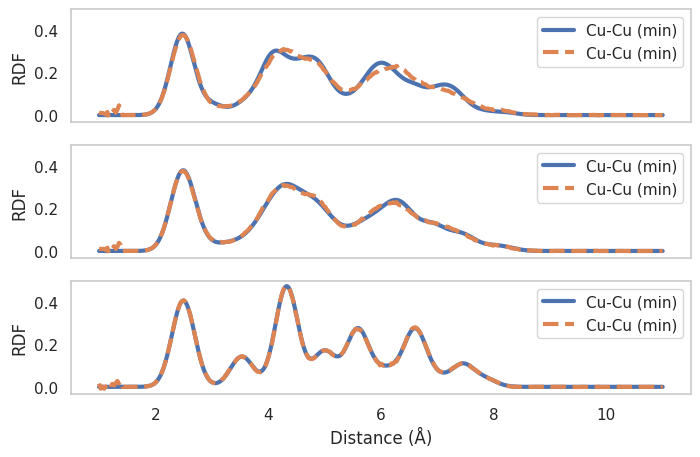

In [ ]:
def plot_rdf(rdf, n_bins, min_dist, max_dist, species, ls=None, lw=None, label="", frame_idx=0, ax=None) -> None:
    """Plot RDFs for a specific frame"""
    if rdf.dim() > 3:  # If we have [frames, channels, 1, bins]
        rdf_frame = rdf[frame_idx].squeeze(1)  # Remove extra dimension
    else:
        rdf_frame = rdf[frame_idx]
    
    if not ax:
        ax = plt.subplot()
    pairs = []
    for i, s1 in enumerate(species):
        for j, s2 in enumerate(species):
            if j >= i:  # Only include upper triangular pairs
                pairs.append(f"{s1}-{s2}")
    
    # Plot each channel with correct pair label
    for i, pair in enumerate(pairs):
        if i < rdf_frame.shape[0]:  # Make sure we don't exceed number of channels
            # Ensure data is 1D for plotting
            y_data = rdf_frame[i].cpu().numpy().flatten()
            sns.lineplot(
                x=np.linspace(min_dist, max_dist, n_bins), 
                y=y_data,
                label=pair+label, 
                ax=ax,
                linestyle=ls if ls else '-',
                linewidth=lw if lw else 1.5,    
            )
    ax.set_xlabel("Distance (Å)")
    ax.set_ylabel("RDF")
    ax.legend()
    ax.grid(False)

import random
fig, axes = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(8, 5))
for i, ax in enumerate(axes):
    idx = random.randint(0, inputs.shape[0] - 1)  # Randomly select a frame index
    for j, rdf in enumerate([inputs, outputs]):
        plot_rdf(rdf, n_bins=340,
                min_dist=1.0,
                max_dist=11.0,
                species=["Cu"],
                frame_idx=idx,
                ax=ax,
                label=" (min)",
                ls='-' if j == 0 else '--', 
                lw=3)


print(f"Inputs shape: {inputs.shape}")
print(f"Outputs shape: {outputs.shape}")

[0.0578555  0.0578551  0.05785531 ... 0.01698635 0.01865483 0.01639217]


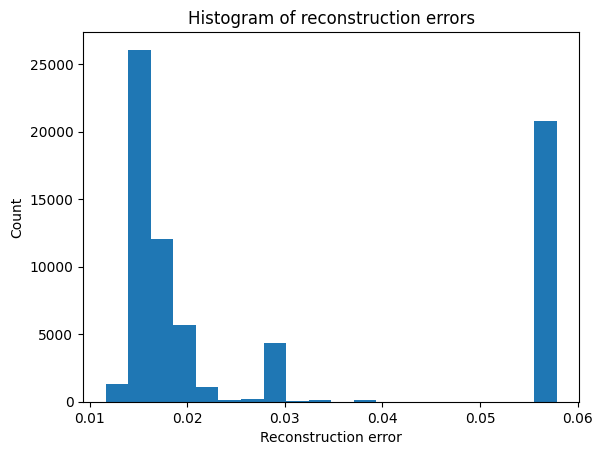

In [ ]:
def reconstruction_errors(recon_errors_file, bins=50):
    """
    Plot the histogram of reconstruction errors using seaborn.
    """
    errors = np.load(recon_errors_file)
    print(errors)
    fig, ax = plt.subplots(1,1, figsize=(7,4))
    sns.histplot(errors, bins=bins, kde=True, ax=ax, color="skyblue")
    ax.set_xlabel('Reconstruction error'); ax.set_ylabel('Count')
    ax.set_title('Histogram of reconstruction errors')
    plt.show()

reconstruction_errors(
    os.path.join(f'{model_dir}/evaluation', f'reconstructed_errors.npy'),
    bins=20
)

In [8]:
def plot_loss_curve(stats_file):
    """
    Plot the training and validation loss curves from a CSV file using seaborn.
    """
    df = pd.read_csv(stats_file)
    fig, ax = plt.subplots(1,1, figsize=(7,4))
    sns.lineplot(x=df['epoch'], y=df['train_loss'], label='train', ax=ax)
    sns.lineplot(x=df['epoch'], y=df['val_loss'], label='val', ax=ax)
    ax.set_xlabel('Epoch'); ax.set_ylabel('Loss')
    ax.legend()
    ax.set_yscale('log')
    plt.tight_layout()

plot_loss_curve(
    os.path.join(f'{stats_dir}', f'stats.dat')
)

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/rasera/PyISV/models/nonMin_to_min_nCu_38/stats/stats.dat'

Embeddings shape: (72000, 2)


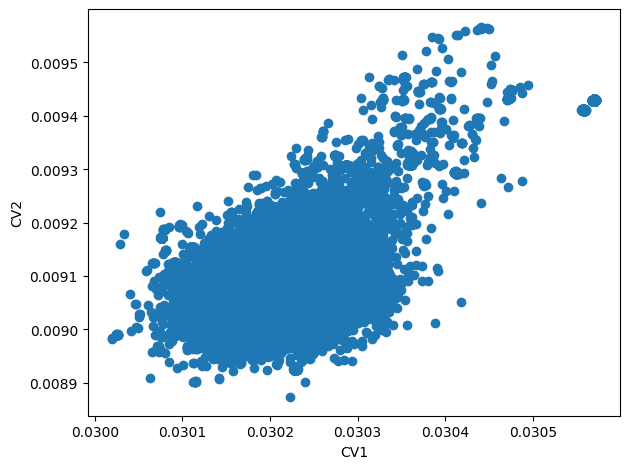

In [ ]:
def embedding_scatter(embedding_file):
    if embedding_file.endswith('.pt'):
        embeddings = torch.load(embedding_file)
        if hasattr(embeddings, 'cpu'):
            embeddings = embeddings.cpu()
        if hasattr(embeddings, 'numpy'):
            embeddings = embeddings.numpy()
    elif embedding_file.endswith('.npy'):
        embeddings = np.load(embedding_file)
    else:
        raise ValueError('Unsupported file type for embeddings.')

    # If embeddings are 3D (e.g., [N,1,2]), squeeze to [N,2]
    print(f"Embeddings shape: {embeddings.shape}")
    if hasattr(embeddings, 'ndim') and embeddings.ndim > 2:
        embeddings = np.squeeze(embeddings)

    fig, ax = plt.subplots(1, 1, figsize=(7,6))
    sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], ax=ax, s=30, color="purple", edgecolor="w", alpha=0.7)
    ax.set_xlabel('CV1'); ax.set_ylabel('CV2')
    plt.tight_layout()

embedding_scatter(
    os.path.join(f'{model_dir}/evaluation', f'embeddings.npy')
)

## Export PyTorch Model to ONNX and Visualize with Netron

This section demonstrates how to export your trained PyTorch model to the ONNX format and visualize its architecture using Netron.



**Steps:**

1. Load your model class and weights.

2. Create a dummy input tensor matching your model's input shape.

3. Export the model to ONNX.

4. Visualize the ONNX file with Netron.



> **Note:** You must have the model class definition available in the notebook. If it's in another file, import it accordingly. Adjust the dummy input shape if your model expects a different input.

In [ ]:
# Visualize with Netron
# Can be installed via pip: pip install netron
# or conda: conda install -c conda-forge netron
import netron

onnx_path = f"{model_dir}/model.onnx"
netron.start(onnx_path)
# This will open a browser window with the model visualization.